# This note book check and validate MBG platform vertical offset computation 
It compare the results between XSF generated between a kmall, a all file created from kmalland a mbg generated from the .all  




## imports some library

In [1]:
import netCDF4  as nc
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

## set the files paths

In [2]:
base_path="D://DATA//file//XSF//CompareMBG-XSF//"
#base_path="D://DATA//file//XSF//OpenBST//"
#base_path="Z://database//Globe_Unit_Test_Dir//file//xsf//XSFValidation//"
filename="0039_20180905_222154.mbg"
file_path_mbg= base_path + filename
file_path_xsf_all= base_path + "0039_20180905_222154_all.xsf"
file_path_xsf_kmall= base_path + "0039_20180905_222154_kmall.xsf"


Create function for matrix rotation and vector definitions


In [3]:
"""
create a rotation matrix from heading pitch, roll
heading pitch and roll are given in degree
"""
def rotationMatrix3(heading, pitch, roll):
    pitch = math.radians(pitch)
    heading = math.radians(heading)
    roll=math.radians(roll)
    pitch11 = math.cos(pitch)
    pitch12 = 0
    pitch13 = math.sin(pitch)
    pitch21 = 0
    pitch22 = 1
    pitch23 = 0
    pitch31 = -math.sin(pitch)
    pitch32 = 0
    pitch33 = math.cos(pitch)

    roll11 = 1
    roll12 = 0
    roll13 = 0

    roll21 = 0
    roll22 = math.cos(roll)
    roll23 = -math.sin(roll)

    roll31 = 0
    roll32 = math.sin(roll)
    roll33 = math.cos(roll)

    heading11 = math.cos(heading)
    heading12 = -math.sin(heading)
    heading13 = 0

    heading21 = math.sin(heading)
    heading22 = math.cos(heading)
    heading23 = 0

    heading31 = 0
    heading32 = 0
    heading33 = 1

    pitchroll11 = pitch11 * roll11 + pitch12 * roll21 + pitch13 * roll31
    pitchroll12 = pitch11 * roll12 + pitch12 * roll22 + pitch13 * roll32
    pitchroll13 = pitch11 * roll13 + pitch12 * roll23 + pitch13 * roll33
    pitchroll21 = pitch21 * roll11 + pitch22 * roll21 + pitch23 * roll31
    pitchroll22 = pitch21 * roll12 + pitch22 * roll22 + pitch23 * roll32
    pitchroll23 = pitch21 * roll13 + pitch22 * roll23 + pitch23 * roll33
    pitchroll31 = pitch31 * roll11 + pitch32 * roll21 + pitch33 * roll31
    pitchroll32 = pitch31 * roll12 + pitch32 * roll22 + pitch33 * roll32
    pitchroll33 = pitch31 * roll13 + pitch32 * roll23 + pitch33 * roll33

    return np.array([[heading11 * pitchroll11 + heading12 * pitchroll21 + heading13 * pitchroll31,
            heading11 * pitchroll12 + heading12 * pitchroll22 + heading13 * pitchroll32,
            heading11 * pitchroll13 + heading12 * pitchroll23 + heading13 * pitchroll33],
        [heading21 * pitchroll11 + heading22 * pitchroll21 + heading23 * pitchroll31,
            heading21 * pitchroll12 + heading22 * pitchroll22 + heading23 * pitchroll32,
            heading21 * pitchroll13 + heading22 * pitchroll23 + heading23 * pitchroll33],
        [heading31 * pitchroll11 + heading32 * pitchroll21 + heading33 * pitchroll31,
            heading31 * pitchroll12 + heading32 * pitchroll22 + heading33 * pitchroll32,
            heading31 * pitchroll13 + heading32 * pitchroll23 + heading33 * pitchroll33]])

""" define a vector3 in python (a numpy array automatically transposed"""
def vector3(x, y, z):
 return np.array([x,y,z]).transpose()
# some test about matrix




Read MBG variables

In [4]:

#read mbg variables
with nc.Dataset(file_path_mbg, format="NETCDF3_CLASSIC") as dataset:
    #get beamGroup dataset
    mbReferenceDepth=np.array(dataset.variables["mbReferenceDepth"])[:,0]
    mbTransmissionHeave=np.array(dataset.variables["mbTransmissionHeave"])[:,0]
    mbRoll=np.array(dataset.variables["mbRoll"])[:,0]
    mbPitch=np.array(dataset.variables["mbPitch"])[:,0]
    tx_Lever=np.array(dataset.mbTxAntennaLeverArm)


read XSF ALL variables

In [5]:
with nc.Dataset(file_path_xsf_all) as dataset:
    #get beamGroup dataset
    beamGroup = dataset['/root/sonar/beam/Beam_group1/']
    platform_vertical_offset_xsf_all = np.array(beamGroup.variables["platform_vertical_offset"])
    tx_transducer_zdepth_all = np.array(beamGroup.variables["tx_transducer_zdepth"])
    platform_roll_all = np.array(beamGroup.variables["platform_roll"])
    platform_pitch_all = np.array(beamGroup.variables["platform_pitch"])
    heave_all = np.array(beamGroup.variables["tx_transducer_zdepth"])

read XSF KMALL variables


In [6]:
with nc.Dataset(file_path_xsf_kmall) as dataset:
    #get beamGroup dataset
    beamGroup = dataset['/root/sonar/beam/Beam_group1/']
    platform_vertical_offset_xsf_kmall = np.array(beamGroup.variables["platform_vertical_offset"])
    platform_roll_kmall = np.array(beamGroup.variables["platform_roll"])
    platform_pitch_kmall = np.array(beamGroup.variables["platform_pitch"])

On vérifie que tx_transducer_zdepth et mbReferenceDepth sont egaux

In [7]:
temp= mbReferenceDepth - tx_transducer_zdepth_all
if np.max(np.abs(temp)) > 0.01:#0.01 scale factor du mbg
    plt.plot(np.abs(temp))
    plt.title("diff mbReferenceDepth-tx_transducer_zdepth (all)")
    plt.show(block=True)
    raise ValueError("difference too high between mbReferenceDepth and tx_transducer_zdepth (all)")


On affiche les informations d'attitude et leurs différences respectives

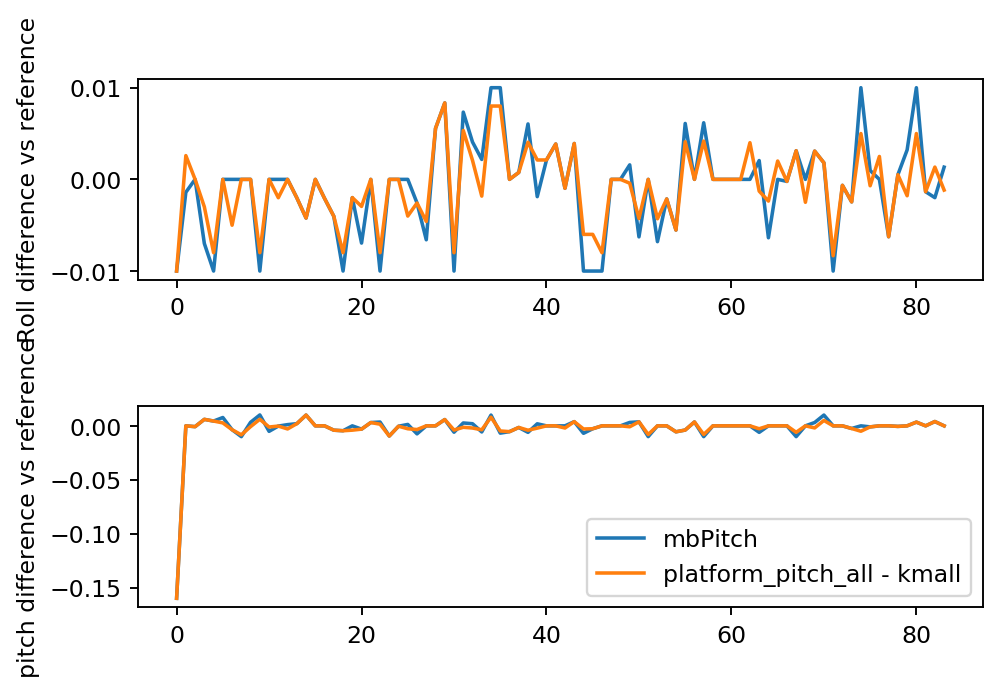

In [8]:
#on agrandit les figures pour Jupyter
plt.rcParams['figure.dpi'] = 170

#On vérifie que les informations d'attitude sont globalement egaux
fig,axs= plt.subplots(2,1)
axs[0].plot(mbRoll-platform_roll_kmall,label="mbRoll")
axs[0].plot(platform_roll_all-platform_roll_kmall, label="platform_roll_all - kmall")
axs[0].set_ylabel("Roll difference vs reference")
axs[1].plot(mbPitch-platform_pitch_kmall,label="mbPitch")
axs[1].plot(platform_pitch_all-platform_pitch_kmall, label="platform_pitch_all - kmall")
axs[1].set_ylabel("pitch difference vs reference")
plt.legend()
fig.tight_layout()

# Calcul du platform vertical offset pour le MBG

In [9]:
mb_platform_vertical_offset=np.empty(len(mbReferenceDepth))
# On récupère les bras de levier
antennaPos=vector3(tx_Lever[0],tx_Lever[1],tx_Lever[2])
for ping,tx_z_depth in enumerate(mbReferenceDepth):
    attitude=rotationMatrix3(0,mbPitch[ping],mbRoll[ping])
    #compute antenna position in SCS referential
    txSCS=np.dot(attitude,antennaPos)
    #Compute platform_vertical_offset
    mb_platform_vertical_offset[ping]=txSCS[2]-tx_z_depth

Affichage des écarts relatifs des vertical offset par rapport au kmall

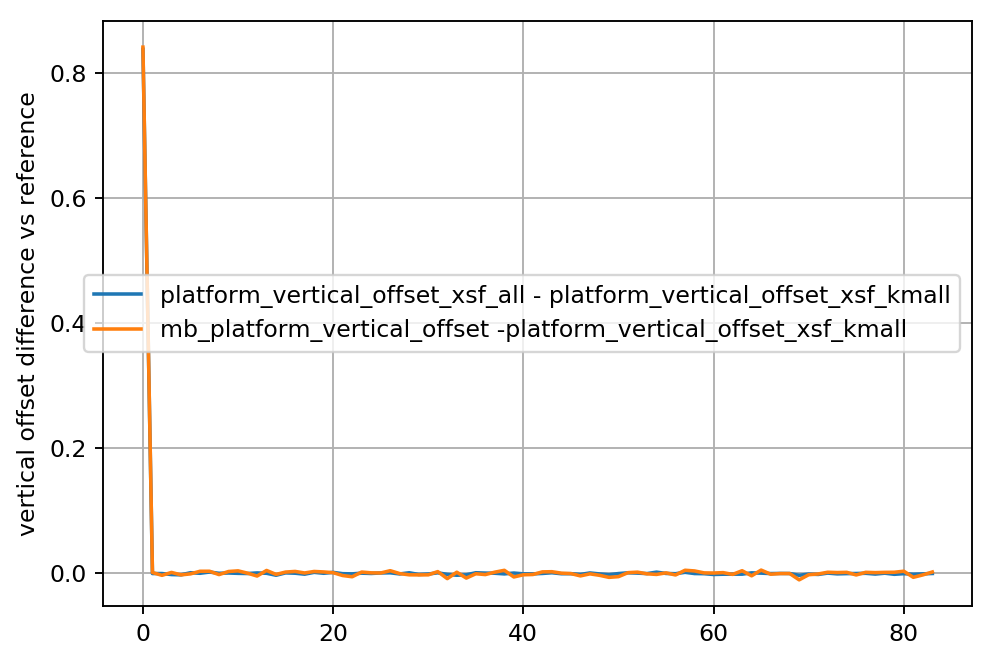

In [10]:

fig, axs = plt.subplots()

axs.plot(platform_vertical_offset_xsf_all-platform_vertical_offset_xsf_kmall, label="platform_vertical_offset_xsf_all - platform_vertical_offset_xsf_kmall")
#plt.plot(platform_vertical_offset_xsf_kmall, label="platform_vertical_offset_xsf_kmall")
axs.plot(mb_platform_vertical_offset-platform_vertical_offset_xsf_kmall,label="mb_platform_vertical_offset -platform_vertical_offset_xsf_kmall ")
#plt.plot(tx_transducer_zdepth,label="tx_transducer_zdepth")
#plt.plot(mbReferenceDepth,label="mbReferenceDepth")
plt.legend()
plt.grid()
axs.set_ylabel("vertical offset difference vs reference")
fig.tight_layout()


# Conclusion
* A revoir l'interpolation pour le mbg et le .all, on a un écart important pour le pitch qui génère un écart aussi important pour l'offset vertical (ping 0)
* Les écarts sont assez minimes entre les différents fichiers